In [1]:

import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

c:\Users\otkul\sintef\repo\qaoa\examples\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


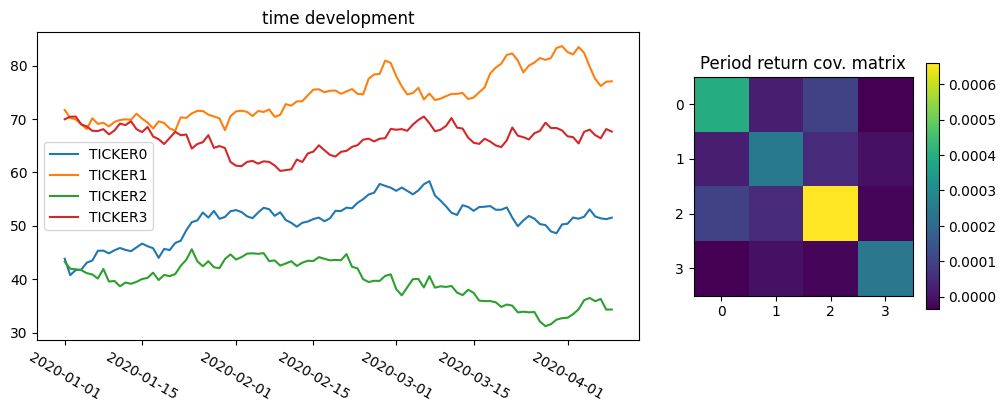

In [2]:
reload(asset_loader)
assets = asset_loader.AssetData(4, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 2,
    "penalty": 4,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": True #only for drawing
}

In [3]:
from qaoa import QAOA, problems, mixers

qaoa_portopt = QAOA(
    problem=problems.PortfolioOptimization,
    mixer=mixers.XY,
    params=params
)

Its now computing the feasible subspace


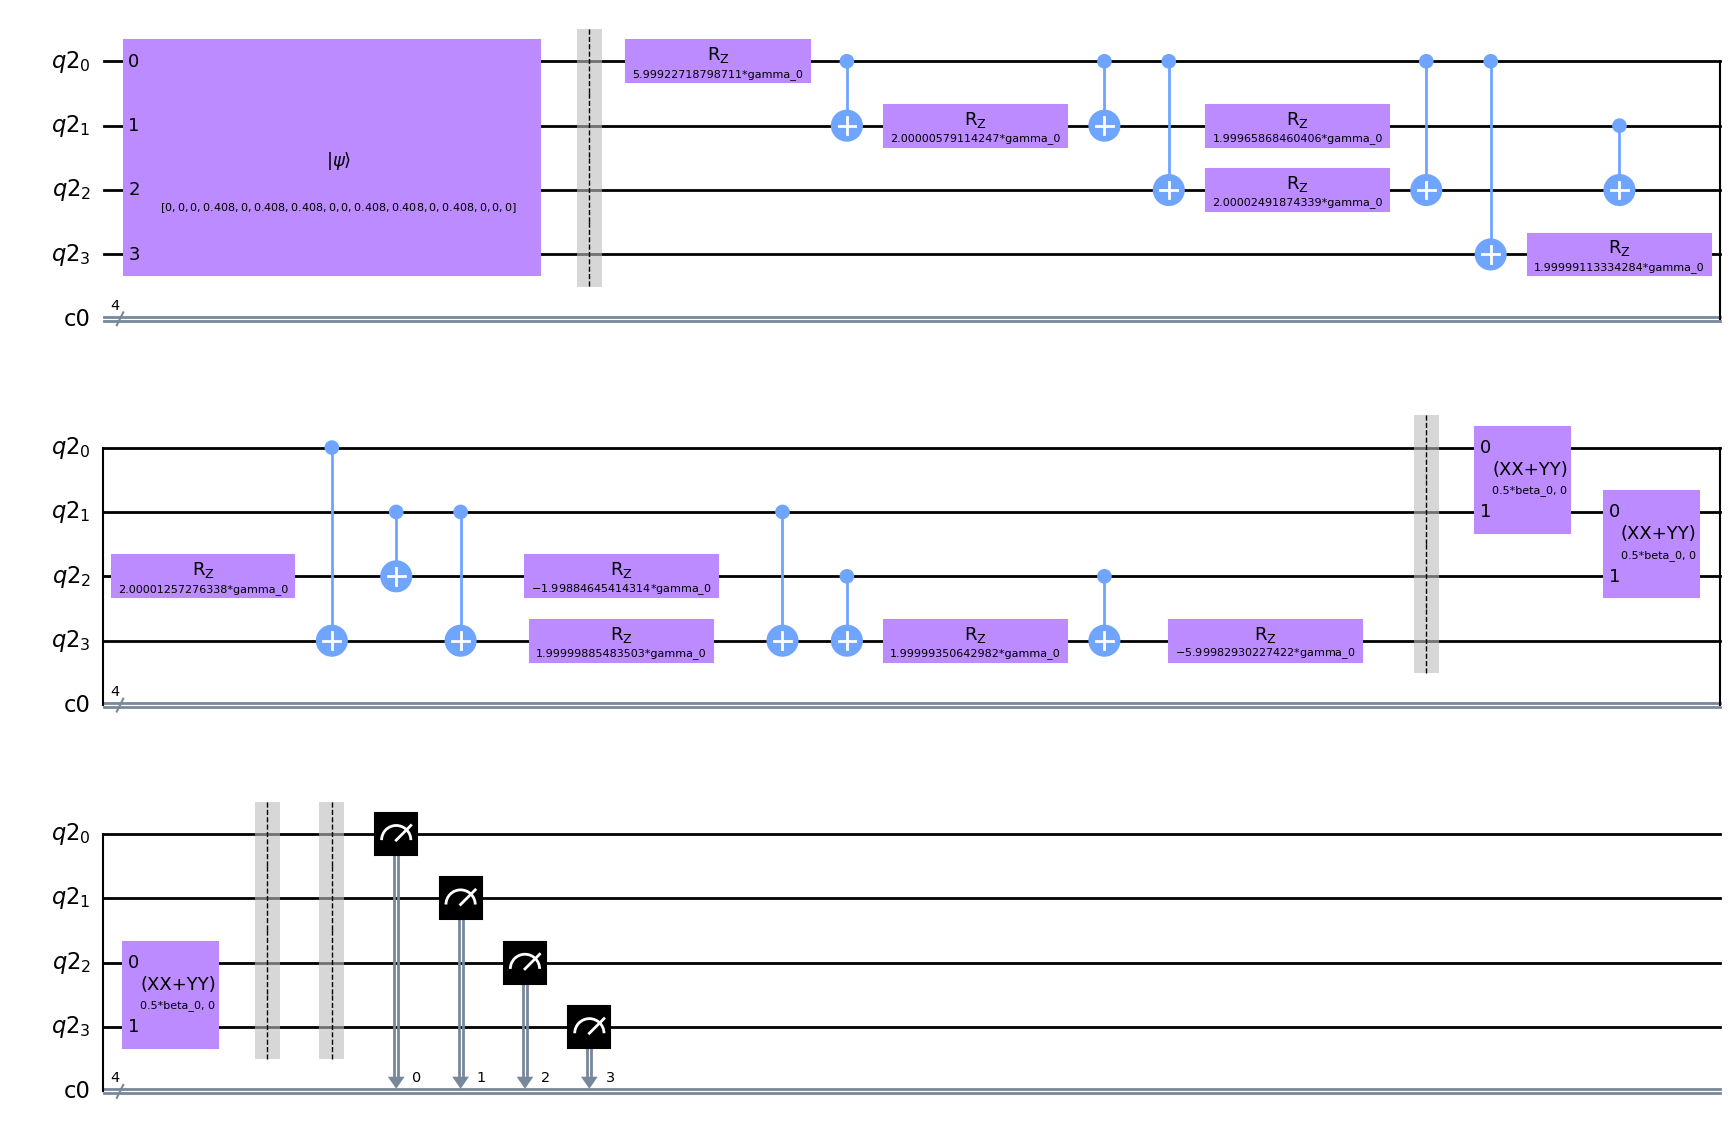

In [4]:
qaoa_portopt.createParameterizedCircuit(1)
display(qaoa_portopt.parameterized_circuit.draw(output='mpl'))


[0.00048258 0.00031392 0.00078376 0.0001755 ]


[0.00056995 0.00033647 0.00060782 0.00024153]
0.0003038673336685753
0.0003038673336685753
0.0003038673336685753
[1. 1. 1.]


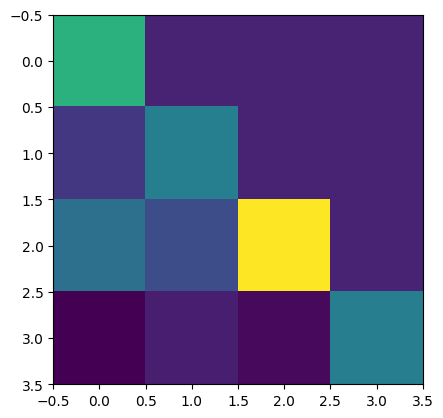

In [5]:
tril_cov = np.tril(qaoa_portopt.cov_matrix + np.tril(qaoa_portopt.cov_matrix, k=-1))
plt.imshow(tril_cov)
print(np.sum(qaoa_portopt.cov_matrix, axis=0))
print(np.sum(tril_cov, axis=0))

x = np.random.rand(4)
print(x.T@(qaoa_portopt.cov_matrix@x))
print(x@(qaoa_portopt.cov_matrix@x))
print(x.T@(tril_cov@x))

print(np.ones((3)))

In [6]:
print(qaoa_portopt.isFeasible("0010"))
print(qaoa_portopt.cost("0010"))
print(qaoa_portopt.cost("0101"))
print(qaoa_portopt.cost("1100"))

print(qaoa_portopt.cost("1000"))



False
-4.002333065994415
0.00039152639381967447
0.0023381735562253425
-3.998367003059391


In [7]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

solutions:
0000 	 -16.0
0001 	 -4.000341395451567
0010 	 -4.002333065994415
0011 -0.0026484871652812103
0100 	 -3.9992716588144965
0101 0.00039152639381967447
0110 -0.0016550158624220046
0111 	 -4.001965856373403
1000 	 -3.998367003059391
1001 0.0013270681176713595
1010 -0.0007997440273825873
1011 	 -4.001079698569619
1100 0.0023381735562253425
1101 	 -3.9979631746068307
1110 	 -4.0001448584652906
1111 	 -16.000420232347622
--------------------
Best sol is 1100 with cost 0.0023381735562253425


## Sample cost landscape

In [8]:
qaoa_portopt.sample_cost_landscape(angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

2023-09-06 11:36:04 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:36:04 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:36:04 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:36:04 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:36:13 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-06 11:36:13 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


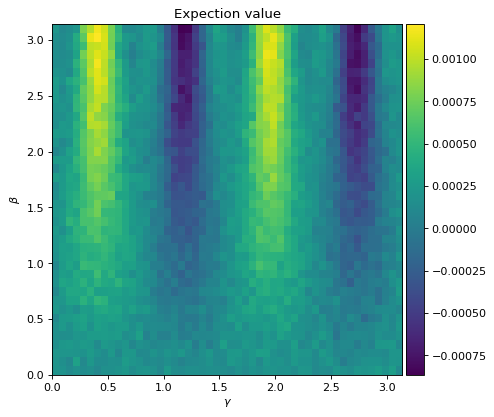

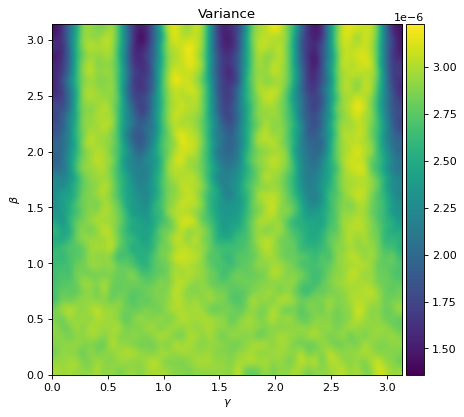

In [9]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [10]:
maxdepth=7
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth()

  0%|          | 0/7 [00:00<?, ?it/s]

2023-09-06 11:36:14 [info     ] cost(depth 1 = -0.0008667920144057042 file=qaoa.qaoa func=increase_depth


 14%|█▍        | 1/7 [00:00<00:03,  1.71it/s]

2023-09-06 11:36:16 [info     ] cost(depth 2 = -0.0020407765479886417 file=qaoa.qaoa func=increase_depth


 29%|██▊       | 2/7 [00:01<00:05,  1.04s/it]

2023-09-06 11:36:18 [info     ] cost(depth 3 = -0.0018957236864894746 file=qaoa.qaoa func=increase_depth


 43%|████▎     | 3/7 [00:04<00:06,  1.57s/it]

2023-09-06 11:36:22 [info     ] cost(depth 4 = -0.0020434712326846956 file=qaoa.qaoa func=increase_depth


 57%|█████▋    | 4/7 [00:07<00:07,  2.37s/it]

2023-09-06 11:36:27 [info     ] cost(depth 5 = -0.0019881283459078874 file=qaoa.qaoa func=increase_depth


 71%|███████▏  | 5/7 [00:13<00:06,  3.48s/it]

2023-09-06 11:36:33 [info     ] cost(depth 6 = -0.001982956169955922 file=qaoa.qaoa func=increase_depth


 86%|████████▌ | 6/7 [00:19<00:04,  4.46s/it]

2023-09-06 11:36:43 [info     ] cost(depth 7 = -0.0021047506919770857 file=qaoa.qaoa func=increase_depth


100%|██████████| 7/7 [00:28<00:00,  4.09s/it]


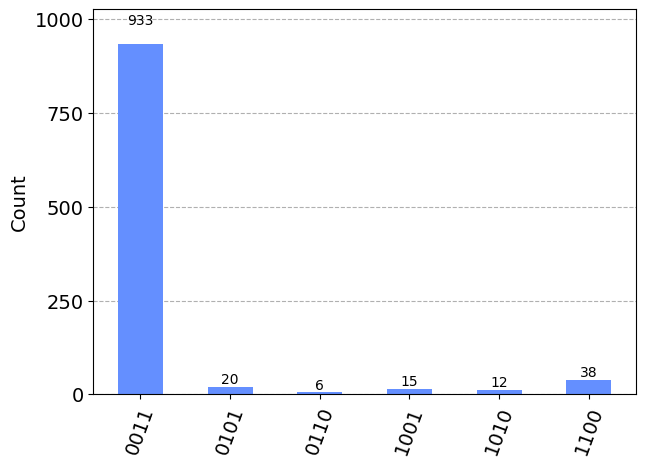

In [11]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'])
plot_histogram(hist)

In [12]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

for s, freq in sorted_hist.items():
    if qaoa_portopt.isFeasible(s):
        print(qaoa_portopt.cost(s), s, freq)
    else:
        print("\t", qaoa_portopt.cost(s), s, freq)

print("Classical best result: ", (best_sol, best_cost))

-0.0026484871652812103 0011 933
0.0023381735562253425 1100 38
0.00039152639381967447 0101 20
0.0013270681176713595 1001 15
-0.0007997440273825873 1010 12
-0.0016550158624220046 0110 6
Classical best result:  ('1100', 0.0023381735562253425)
